# RadIOCD

In [1]:
# Download RadIOCD
# !wget https://zenodo.org/records/10731407/files/RadIOCD.zip
# !wget https://zenodo.org/records/10731407/files/df_4_annotation.csv
# !unzip RadIOCD.zip

In [14]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [15]:
path = 'dataset/'
subjects = ['subject_1/', 'subject_2/', 'subject_3/', 'subject_4/', 'subject_5/', 
            'subject_6/', 'subject_7/', 'subject_8/', 'subject_9/', 'subject_10/'] 

classes = {'wall':4,'human':3,'desk':2,'chair':1,'backpack':0}

In [16]:
# read df_4_annotation.csv to simplify io and feature extraction
df_4_annotation = pd.read_csv('df_4_annotation.csv')
dfs_csvs = df_4_annotation['CSV'].unique()

In [17]:
threshold_frames = 8 #how many frames in a csv file should contain the object of interest
threshold_gap = 2 #how many frames in a specified window should not contain the object of interest
window = 10 #how many frames contitute a window
eps = 0.5 #the maximum distance between two samples 

In [18]:
# init features daraframe
features = pd.DataFrame({'object':[],'subject':[],'min_X':[],'max_X':[],'mean_X':[],'std_X':[],'env':[],
                                        'min_Y':[],'max_Y':[],'mean_Y':[],'std_Y':[],
                                        'min_Z':[],'max_Z':[],'mean_Z':[],'std_Z':[],'csv':[]})

In [37]:
def get_closest_cluster(filtered_points_df, eps, threshold_frames):
    estimate_feature = False
    clustering = DBSCAN(eps=eps, min_samples=threshold_frames).fit(filtered_points_df)
    uniq = np.unique(clustering.labels_)
    distances = []
    indices = []
    for un in uniq:
        points = filtered_points_df.iloc[np.where(clustering.labels_==un)[0]]
        if len(points)>0:
            mean_x = points['X'].mean()
            mean_y = points['Y'].mean()
            mean_z = points['Z'].mean()

            d = np.sqrt(mean_x**2+mean_y**2+mean_z**2)
            # objects over 0.3m at the left or right are considerd to be far away.
            if np.abs(mean_x)<0.3 and (un!=-1):

                if d<=0.0:
                    continue
                else:
                    distances.append(d)
                    indices.append(un)
    if len(distances)>0:
        # the object in the closest distance should be the object of interest
        index_ = np.argmin(distances)
        un_index = indices[index_]
        estimate_feature = True

        points_df = filtered_points_df.iloc[np.where(clustering.labels_==un_index)[0]]
        return points_df, estimate_feature
    else:
        return None, estimate_feature

In [38]:
# iterate over the csv files 
for i in tqdm(dfs_csvs):
    cdf = pd.read_csv(i)
    splits = i.split('/')
    current_subject = splits[1]
    current_env = splits[2]
    current_object = splits[3]
    current_csv = i
    
    #check if there is an object detected in the current csv file
    if 'Presence' in cdf.columns:
        #check how many frames contain an object 
        un_frames = cdf['Frame #'][cdf['Presence']==1].unique()

        if len(un_frames)<threshold_frames:
            continue
        else:
            for gr in un_frames:
                array = np.arange(gr,gr+window)
                set1 = set(array) 
                set2 = set(un_frames) 
                
                #if the are more "empty" frames than the defined threshold continue
                if len(set1.union(set2))-len(set2)>threshold_gap:
                    continue
                elif (array[-1] not in cdf['Frame #'].values):
                    continue
                else:
                    current_cdf = cdf[(cdf['Frame #']>=array[0]) & (cdf['Frame #']<=array[-1])]
                    if len(current_cdf['Frame #'].unique())<(window-1):
                        print('Error less than expected frames')
                    points_df = current_cdf[current_cdf['Presence']==1]
                    filtered_points_df = points_df[['X','Y','Z']][(points_df['Doppler'].abs()>0)]
                    
                    #apply DBSCAN over all the sparse point clouds contained in the window
                    points_df, estimate_feature = get_closest_cluster(filtered_points_df, eps, threshold_frames)                    
                    
                    if estimate_feature:   
                    #Get values only if the object is closer than 2.5 meters
                        if np.mean(points_df['Y'])<2.5 and np.mean(points_df['Y'])>1. and np.abs(np.mean(points_df['Z'])<1):
                            current_features = pd.DataFrame({'object':[current_object],'subject':[current_subject],'env':[current_env],
                                                             'min_X':[np.min(points_df['X'])],'max_X':[np.max(points_df['X'])],
                                                             'mean_X':[np.mean(points_df['X'])],'std_X':[np.std(points_df['X'])],
                                                             'min_Y':[np.min(points_df['Y'])],'max_Y':[np.max(points_df['Y'])],
                                                             'mean_Y':[np.mean(points_df['Y'])],'std_Y':[np.std(points_df['Y'])],
                                                             'min_Z':[np.min(points_df['Z'])],'max_Z':[np.max(points_df['Z'])],
                                                             'mean_Z':[np.mean(points_df['Z'])],'std_Z':[np.std(points_df['Z'])],
                                                            'n_points':[len(points_df)],'csv':[current_csv]})
                            features = pd.concat([features,current_features],ignore_index=True)

100%|██████████| 5776/5776 [07:06<00:00, 13.53it/s]


In [40]:
# store features to csv file
features.to_csv('features.csv',index=False)

In [41]:
features = pd.read_csv('features.csv')

In [42]:
features = features.replace(classes)

In [43]:
features = features.replace({'subject_1': 1,'subject_2': 2,'subject_3': 3,
                            'subject_4': 4,'subject_5': 5,'subject_6': 6,
                            'subject_7': 7,'subject_8': 8,'subject_9': 9,'subject_10': 10, })

In [44]:
#define set of features
feats = ['min_X', 'max_X', 'mean_X', 'std_X','min_Y', 'max_Y', 'mean_Y', 'std_Y', 'min_Z', 
         'max_Z', 'mean_Z','std_Z','n_points']

# ML subject-dependent 

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [46]:
kf = KFold(n_splits=10, random_state=12, shuffle=True)

In [47]:
def z_score(X_train, X_test):
    x_means = np.zeros(len(feats))
    x_stds = np.zeros(len(feats))
    for i in range(len(feats)):
        x_means[i] = np.mean(X_train[:,i])
        x_stds[i] = np.std(X_train[:,i])

        X_train[:,i] = (X_train[:,i]-x_means[i])/x_stds[i]
        X_test[:,i] = (X_test[:,i]-x_means[i])/x_stds[i]
    return X_train, X_test

In [48]:
test_acc = []
conf_mats = []
f1s = []

for i, (train_index, test_index) in enumerate(kf.split(features['csv'].unique())):
    csv_train = features['csv'].unique()[train_index]
    csv_test = features['csv'].unique()[test_index]

    X_train = features[feats][(features['csv'].isin(csv_train))].to_numpy()
    y_train = features['object'][(features['csv'].isin(csv_train))].to_numpy()

    X_test = features[feats][(features['csv'].isin(csv_test))].to_numpy()
    y_test = features['object'][(features['csv'].isin(csv_test))].to_numpy()
    
    X_train, X_test = z_score(X_train, X_test)
      
    # change this accordingly
    rf = RandomForestClassifier(n_estimators=30, max_depth=20)
    rf.fit(X_train,y_train)
    
    test_acc.append(np.mean(rf.predict(X_test)==y_test))
    preds = rf.predict(X_test)
    
    print('Train:',np.mean(rf.predict(X_train)==y_train))
    print('Test:',np.mean(rf.predict(X_test)==y_test))
    print(f1_score(y_test, preds, average='macro'))

    conf_mats.append(confusion_matrix(y_test,preds, labels=[0,1,2,3,4]))
    f1s.append(f1_score(y_test, preds, average='macro'))
print()
print(np.mean(test_acc))
print(np.mean(f1s))

Train: 0.9950347264530279
Test: 0.7357180993059264
0.6931225299990276
Train: 0.994470509383378
Test: 0.7618666666666667
0.7153418188496448
Train: 0.9941013185287995
Test: 0.7473039930049549
0.7009354646742159
Train: 0.9954167425484125
Test: 0.7464167585446527
0.7071318506166148
Train: 0.9947053617748481
Test: 0.7570302233902759
0.6967016263568875
Train: 0.9943128535559791
Test: 0.7264714245095252
0.683066250187229
Train: 0.9951353734360986
Test: 0.7517306909189629
0.6964254013644612
Train: 0.9957626472784916
Test: 0.7850417716483225
0.7284443126122158
Train: 0.9952677081753375
Test: 0.7625380991964533
0.7118376546483333
Train: 0.9949453551912568
Test: 0.7362410566868465
0.6875233234901403

0.7510358783872586
0.702053023279877


Text(33.0, 0.5, 'Predicted class')

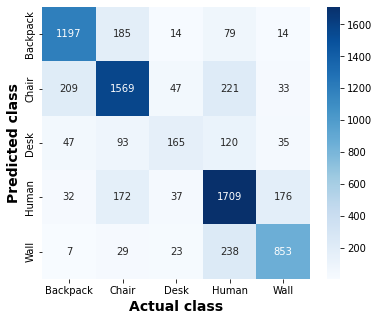

In [49]:
import seaborn as sn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 1000
%matplotlib inline
classe = ["Backpack", "Chair", "Desk", "Human", "Wall"]

mean_cf = np.mean([i for i in conf_mats],0)
mean_cf

df_cm = pd.DataFrame(mean_cf.astype(int), index = [i for i in classe],columns = [i for i in classe])
plt.figure(figsize = (6,5))


ax = sn.heatmap(df_cm, annot=True,fmt='g',cmap='Blues')

ax.set_xlabel(xlabel='Actual class', fontsize=14, fontdict=dict(weight='bold'))
ax.set_ylabel(ylabel='Predicted class', fontsize=14, fontdict=dict(weight='bold'))

# ML Subject Independent

In [50]:
test_acc = []
conf_mats = []
f1s = []
for s in range(1,11):
    X_train = features[feats][(features['subject']!=s)].to_numpy()
    y_train = features['object'][(features['subject']!=s)].to_numpy()

    X_test = features[feats][(features['subject']==s)].to_numpy()
    y_test = features['object'][(features['subject']==s )].to_numpy()
    
    X_train, X_test = z_score(X_train, X_test)
        
    rf = RandomForestClassifier(n_estimators=30, max_depth=20)
    rf.fit(X_train,y_train)
    
    test_acc.append(np.mean(rf.predict(X_test)==y_test))
    preds = rf.predict(X_test)
    
    print('Train:',np.mean(rf.predict(X_train)==y_train))
    print('Test:',np.mean(rf.predict(X_test)==y_test))
    print(f1_score(y_test, preds, average='macro'))

    conf_mats.append(confusion_matrix(y_test,preds, labels=[0,1,2,3,4]))
    f1s.append(f1_score(y_test, preds, average='macro'))
print()
print(np.mean(test_acc))
print(np.mean(f1s))

Train: 0.9932447608023358
Test: 0.7660313093600576
0.7323322241728515
Train: 0.9959470086504144
Test: 0.6476366742596811
0.5660779925717823
Train: 0.9950629738322329
Test: 0.712325220093216
0.652073956810846
Train: 0.9950477128252654
Test: 0.5052580092932257
0.4372081029988809
Train: 0.9950529409158705
Test: 0.6335849751426993
0.556146092556784
Train: 0.9941503971494321
Test: 0.6323148627654065
0.5539000328887225
Train: 0.9942870535845076
Test: 0.6927488734125359
0.6065273843339336
Train: 0.9951633128321491
Test: 0.6753246753246753
0.6546106937591498
Train: 0.9953240840434368
Test: 0.6569953282517826
0.6072178018066531
Train: 0.9955351606101948
Test: 0.8498380379453957
0.8225832723949029

0.6772057965848675
0.6188677554294507


Text(33.0, 0.5, 'Predicted class')

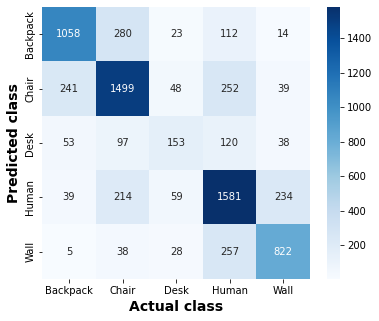

In [51]:
classe = ["Backpack", "Chair", "Desk", "Human", "Wall"]

mean_cf = np.mean([i for i in conf_mats],0)
mean_cf

df_cm = pd.DataFrame(mean_cf.astype(int), index = [i for i in classe],columns = [i for i in classe])
plt.figure(figsize = (6,5))


ax = sn.heatmap(df_cm, annot=True,fmt='g',cmap='Blues')

ax.set_xlabel(xlabel='Actual class', fontsize=14, fontdict=dict(weight='bold'))
ax.set_ylabel(ylabel='Predicted class', fontsize=14, fontdict=dict(weight='bold'))

# Deep Learning Subject Dependent

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-03-01 11:23:27.516926: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 11:23:29.321571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-01 11:23:34.602816: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [55]:
test_acc = []
conf_mats = []
f1s = []

for i, (train_index, test_index) in enumerate(kf.split(features['csv'].unique())):
    csv_train = features['csv'].unique()[train_index]
    csv_test = features['csv'].unique()[test_index]

    X_train = features[feats][(features['csv'].isin(csv_train))].to_numpy()
    y_train = features['object'][(features['csv'].isin(csv_train))].to_numpy()

    X_test = features[feats][(features['csv'].isin(csv_test))].to_numpy()
    y_test = features['object'][(features['csv'].isin(csv_test))].to_numpy()
    
    X_train, X_test = z_score(X_train, X_test)
        
    Y_train = to_categorical(y_train, num_classes=5)
    Y_test = to_categorical(y_test, num_classes=5)

    model = Sequential()
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(5, activation='softmax'))

    early_stopping = EarlyStopping(monitor='val_accuracy',patience=50, mode='max')

    model.build(input_shape=X_train.shape)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    checkpoint = ModelCheckpoint('best_weights_dense_'+str(i)+'.hdf5', 
                                 monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

#     model.summary()
    model.fit(X_train, Y_train, batch_size=128, epochs=1000, 
              validation_data=(X_test, Y_test), verbose=0, callbacks=[early_stopping, checkpoint])
    model.load_weights('best_weights_dense_'+str(i)+'.hdf5')
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    
    preds = np.argmax(model.predict(X_test),1)
    test_acc.append(np.mean(preds==y_test))
    print(f1_score(y_test, preds, average='macro'))

    conf_mats.append(confusion_matrix(y_test,preds, labels=[0,1,2,3,4]))
    f1s.append(f1_score(y_test, preds, average='macro'))
print()
print(np.mean(test_acc))
print(np.mean(f1s))



235/235 [==============================] - 0s 671us/step
0.7277514197776224
235/235 [==============================] - 0s 806us/step
0.7359356659758477
215/215 [==============================] - 0s 797us/step
0.729927979157157
227/227 [==============================] - 0s 806us/step
0.7144969804800042
238/238 [==============================] - 0s 798us/step
0.7302446567009747
220/220 [==============================] - 0s 389us/step
0.7071528473183399
231/231 [==============================] - 0s 867us/step
0.7271398604543553
236/236 [==============================] - 0s 542us/step
0.7284723342776875
226/226 [==============================] - 0s 928us/step
0.7267640919465695
228/228 [==============================] - 0s 762us/step
0.727039511167671

0.7653225554554408
0.725492534725623


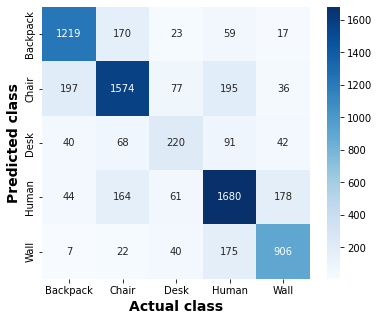

In [56]:
import seaborn as sn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300
%matplotlib inline
classe = ["Backpack", "Chair", "Desk", "Human", "Wall"]

mean_cf = np.mean([i for i in conf_mats],0)
mean_cf

df_cm = pd.DataFrame(mean_cf.astype(int), index = [i for i in classe],columns = [i for i in classe])
plt.figure(figsize = (6,5))


ax = sn.heatmap(df_cm, annot=True,fmt='g',cmap='Blues')

ax.set_xlabel(xlabel='Actual class', fontsize=14, fontdict=dict(weight='bold'))
ax.set_ylabel(ylabel='Predicted class', fontsize=14, fontdict=dict(weight='bold'))

plt.savefig('conf_mat_1.png', dpi=300)

# Deep Learning Subject Independent

In [58]:
test_acc = []
conf_mats = []
f1s = []

for s in range(1,11):
    X_train = features[feats][(features['subject']!=s)].to_numpy()
    y_train = features['object'][(features['subject']!=s)].to_numpy()

    X_test = features[feats][(features['subject']==s)].to_numpy()
    y_test = features['object'][(features['subject']==s )].to_numpy()
    
    X_train, X_test = z_score(X_train, X_test)
    
    Y_train = to_categorical(y_train, num_classes=5)
    Y_test = to_categorical(y_test, num_classes=5)

    model = Sequential()
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(5, activation='softmax'))

    early_stopping = EarlyStopping(monitor='val_accuracy',patience=50, mode='max')

    model.build(input_shape=X_train.shape)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    checkpoint = ModelCheckpoint('best_weights_dense_losos_'+str(s)+'.hdf5', 
                                 monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

    #model.summary()
    model.fit(X_train, Y_train, batch_size=128, epochs=1000, verbose=0,
              validation_data=(X_test, Y_test), callbacks=[early_stopping, checkpoint])
    model.load_weights('best_weights_dense_losos_'+str(s)+'.hdf5')
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    
    preds = np.argmax(model.predict(X_test),1)
    test_acc.append(np.mean(preds==y_test))
    print(f1_score(y_test, preds, average='macro'))

    conf_mats.append(confusion_matrix(y_test,preds, labels=[0,1,2,3,4]))
    f1s.append(f1_score(y_test, preds, average='macro'))
print()
print(np.mean(test_acc))
print(np.mean(f1s))



478/478 [==============================] - 0s 780us/step
0.7347608742261312
220/220 [==============================] - 0s 695us/step
0.590037667653759
242/242 [==============================] - 0s 711us/step
0.6891943579976594
128/128 [==============================] - 0s 749us/step
0.49072122371206106
170/170 [==============================] - 0s 887us/step
0.5935678709265457
182/182 [==============================] - 0s 837us/step
0.5927297695073215
153/153 [==============================] - 0s 797us/step
0.6743650840730993
193/193 [==============================] - 0s 863us/step
0.6571903620505575
255/255 [==============================] - 0s 907us/step
0.646189574389062
271/271 [==============================] - 0s 700us/step
0.8190291616481643

0.7044284869554543
0.6487785946184361


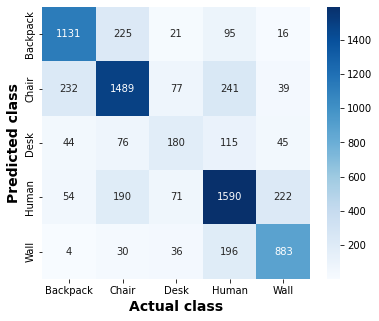

In [59]:
classe = ["Backpack", "Chair", "Desk", "Human", "Wall"]

mean_cf = np.mean([i for i in conf_mats],0)
mean_cf

df_cm = pd.DataFrame(mean_cf.astype(int), index = [i for i in classe],columns = [i for i in classe])
plt.figure(figsize = (6,5))


ax = sn.heatmap(df_cm, annot=True,fmt='g',cmap='Blues')

ax.set_xlabel(xlabel='Actual class', fontsize=14, fontdict=dict(weight='bold'))
ax.set_ylabel(ylabel='Predicted class', fontsize=14, fontdict=dict(weight='bold'))

plt.savefig('conf_mat_2.png', dpi=300)